# Mietpreisprognose

Vorgehen
-aktuelle Daten Sammeln
-Mit hsytorischen Mietspiegeln zurückrechnen und somit hystorische Daten erstellen
-Atribute Finden, die ein vollkommenes Modell bilden könnten (hier Eingeschränkt, da Atribute/exogene VAriablen theoretisch immer weiter konkretisierbar)
-Gewichte der Atribute (zum Beispiel mittels Heat-Map)

Modell bauen:
-Prognose von Rafferenzmieten durch Schätzung mit Möglicher Anpassung von Atributen
-Schätzmodell Für Mieten, durch Standortnahe Refferenzmieten (Refferenzmieten können dabei Prognostiziert werden)



# Datenaufbereitung

## Hinzufügen von Koordinaten

Adressen mittels der Google-Geocode-API in Koordinaten umwandeln um nummerische Daten für weiteren Berechnung zu erhalten

In [ ]:
import json
import requests
import time
import os
from tqdm import tqdm

# Lade die Daten
def load_data(file_name):
    with open(file_name, 'r', encoding='utf-8') as file:
        loaded_data = json.load(file)
    return loaded_data

# Sonderzeichen behandeln
def handle_special_characters(value):
    if isinstance(value, str):  # Überprüfen, ob der Wert ein String ist
        # Umlaute umwandeln
        value = value.replace("ß", "ss")
        value = value.replace("ä", "ae")
        value = value.replace("Ä", "Ae")
        value = value.replace("Ü", "Ue")
        value = value.replace("ü", "ue")
        value = value.replace("ö", "oe")
    return value

# Sonderzeichen in den geladenen Daten ersetzen
def handle_special_chars_in_data(loaded_data):
    decoded_data = []
    for dictionary in loaded_data:
        new_dict = {}
        for key, value in dictionary.items():
            new_dict[key] = handle_special_characters(value)
        decoded_data.append(new_dict)
    return decoded_data

# Funktion zum Formatieren der Adresse
def format_address(item):
    bundesland = item['bundesland']
    stadtteil = item['stadtteil']
    stadt = item['stadt']
    strasse = item.get('strasse', '')  # Falls 'strasse' nicht vorhanden ist, setze einen leeren String
    plz = item['plz']
    return f"{strasse}, {plz} {stadtteil}, {stadt}, {bundesland}"

# Gehe durch die ursprünglichen Daten und formatiere die Adressen
def format_addresses(decoded_data):
    new_data = []
    for item in tqdm(decoded_data, desc="Adressformatierung", total=len(decoded_data)):
        address = format_address(item)
        item['address'] = address
        new_data.append(item)
    return new_data

def geocode_google(address, api_key):
    # Geocodierung einer Adresse
    url = f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={api_key}"
    response = requests.get(url)
    data = response.json()
    if data['results']:
        location = data['results'][0]['geometry']['location']
        return location['lat'], location['lng']
    else:
        return None, None

# Speichern der endgültigen Daten in eine JSON-Datei
def save_to_json(data, output_filename):
    with open(output_filename, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False, indent=2)

def main():
    api_key = "Private_Google_key!!!"
    input_filename = "trainingData.json"
    output_filename = "trainingData_located.json"
    
    # Lade die Daten ein
    loaded_data = load_data(input_filename)

    # Handle special characters
    decoded_data = handle_special_chars_in_data(loaded_data)
    
    # Format addresses
    new_data = format_addresses(decoded_data)

    for item in new_data:
        address = item['address']

        # Geocodierung der Adresse
        latitude, longitude = geocode_google(address, api_key)

        # Fügt die geocodierten Daten zu den vorhandenen Daten hinzu
        if latitude and longitude:
            item['Latitude'] = latitude
            item['Longitude'] = longitude
        
    # Speichern der endgültigen Daten in eine JSON-Datei
    save_to_json(new_data, output_filename)

if __name__ == "__main__":
    main()

### Anzeigen der Datenpunkte

In [ ]:
import folium
import json

# Lese die JSON-Datei ein
with open('trainingData_located20XX.json', 'r') as file:
    data = json.load(file)

# Erstelle eine Karte von Deutschland
map = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

# Iteriere über die Datenpunkte und füge Marker zur Karte hinzu
for item in data:
    latitude = float(item['Latitude'])
    longitude = float(item['Longitude'])
    bundesland = item['bundesland']
    stadtteil = item['stadtteil']
    stadt = item['stadt']
    strasse = item.get('strasse', '')
    plz = item['plz']
    address = f"{strasse}, {plz} {stadtteil}, {stadt}, {bundesland}"

    # Erstelle einen blauen Punkt mit einer Pixelgröße von 2
    folium.CircleMarker(location=[latitude, longitude], radius=0.5, color='blue', fill=True, fill_color='blue').add_to(map)

# Zeige die Karte an
map

## Hystorische Daten mittels lokalen Mietpreisspiegeln erstellen
Aufgrund nicht ausreichend vorhandene Daten von Mietpreisspiegelhystorien und eine ungenügende Anzahl an Hystorischen Mietpreisen, ist man mit den gesammelten Mietpiegel lediglich in der Lage, die Rückberechnung der Grösstenm Städte Deutschlands zu vollziehen.

In [8]:
import json
import os

# Pfad zur Ausgangsdatei mit den Standortdaten
input_file_path = "trainingData_located20XX.json"

# Pfad zum Ordner mit den Mietpreisentwicklungsdateien für die Städte
rent_prices_folder_path = "Mietspiegel_Calculation"

# Zielstädte, nach denen gefiltert werden soll
target_cities = ["Berlin", "Bremen", "Dortmund", "Hamburg", "München"]

# Jahre, für die die Mietpreise zurückgerechnet werden sollen (von 2010 bis 2020)
target_years = range(2010, 2021)

# Neuer Pfad für die gespeicherten Dateien
output_folder_path = "Historical_Data"

# Überprüfen, ob der Zielordner existiert, und erstellen, wenn nicht
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

for target_year in target_years:
    adjusted_data = []  # Liste zur Speicherung aller angepassten Daten für das Zieljahr

    for target_city in target_cities:
        # JSON-Datei mit den Standortdaten öffnen und Daten laden
        with open(input_file_path, "r") as input_file:
            data = json.load(input_file)

        # Pfad zur Mietpreisentwicklungsdatei für die Zielstadt und das Zieljahr
        rent_prices_file_path = os.path.join(rent_prices_folder_path, f"Mietpreisspiegel {target_city}.json")

        # JSON-Datei mit der Mietpreisentwicklung öffnen und Daten laden
        with open(rent_prices_file_path, "r") as rent_prices_file:
            rent_prices_data = json.load(rent_prices_file)

        # Filterung der Standortdaten nach der Zielstadt
        filtered_data = [entry for entry in data if entry["stadt"] == target_city]

        # Mietpreis für das Zieljahr in der Mietpreisentwicklung der Stadt finden
        target_rent_price = next(
            entry["Kaltmiete in Euro/mÂ²"]
            for entry in rent_prices_data
            if entry["Jahr"] == target_year
        )

        # Mietpreise in den Standortdaten entsprechend anpassen
        for entry in filtered_data:
            entry["rent"] = float(target_rent_price.replace(",", ".")) * entry["livingSpace"]

        # Angepasste Daten zur Liste hinzufügen
        adjusted_data.extend(filtered_data)

    # Pfad zur JSON-Datei für die angepassten Standortdaten erstellen
    output_file_path = os.path.join(output_folder_path, f"trainingData_located{target_year}_AllCities_AdjustedRent.json")

    # JSON-Datei für die angepassten Standortdaten erstellen und speichern
    with open(output_file_path, "w") as output_file:
        json.dump(adjusted_data, output_file, indent=4)

## Hinzufügen von Exogenen Variablen
Die hystorischen Datensätze ergänzen

# 1) Standortbasierte Mietpreisschätzung unter Berücksichtigung von Referenzmieten

### KI Modell mit Refferezpunkte

100%|██████████| 795/795 [00:23<00:00, 34.54it/s]


5/5 [==============================] - 0s 4ms/step
RMSE per sqm: 2.235600


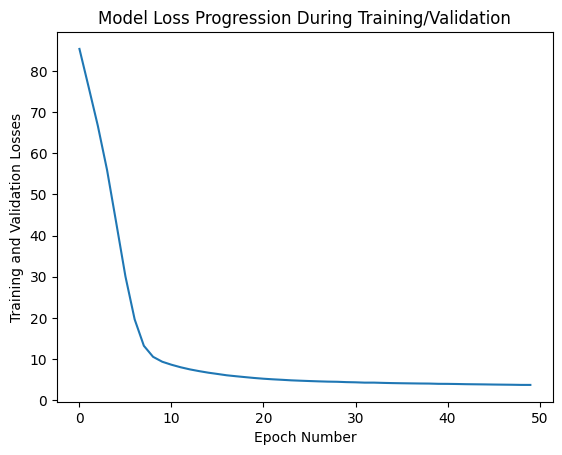

In [9]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import RootMeanSquaredError
import joblib
import json
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import warnings
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
warnings.filterwarnings('ignore', 'sindex.nearest', FutureWarning)
from sklearn.neighbors import KDTree
from tqdm import tqdm

# Load the data
with open("smallDataTest.json", "r") as file: #trainingData_located20XX.json  #smallDataTest.json -> Hier muss auf den Datensatz der gewünschren ZEit zurückgegriffen werden
    data = json.load(file)

filtered_data = []
for entry in data:
    if 'livingSpace' in entry and 'rent' in entry:
        filtered_data.append(entry)

df = pd.DataFrame(filtered_data)
df['quadratmeterpreis'] = df['rent'] / df['livingSpace']

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
gdf_sindex = gdf.sindex

bool_columns = ["hasBasement", "hasBalcony", "hasGarden", "hasElevator"]
for column in bool_columns:
    df[column] = df[column].map({True: 1, False: 0, np.nan: 0.5})

df["houseType"] = df["houseType"].astype("category").cat.codes
df["quadratmeterpreis"] = df["rent"] / df["livingSpace"]
df = df.dropna(subset=['rent', 'livingSpace'])

# Erstellen Sie ein Array mit den Punkt-Koordinaten
coords = gdf[['Longitude', 'Latitude']].values

# Erstellen Sie eine KDTree
tree = KDTree(coords)

def find_nearby(row, gdf, tree, radius=0.01):
    # Die query-Methode der KDTree gibt einen Abstand und den Index des nächsten Punkts zurück
    indices = tree.query_radius(row[['Longitude', 'Latitude']].values.reshape(1, -1), r=radius)
    indices = indices[0]  # Die Ausgabe ist ein Array von Arrays, wir brauchen nur das erste Array
    potential_matches = gdf.iloc[indices]
    precise_matches = potential_matches[potential_matches.distance(row['geometry']) <= radius]
    if len(precise_matches) < 5:
        _, indices = tree.query(row[['Longitude', 'Latitude']].values.reshape(1, -1), k=5)
        precise_matches = gdf.iloc[indices[0]]
    desc = precise_matches['quadratmeterpreis'].describe().drop(['25%', '50%', '75%'])
    desc.index = ['count_nearby', 'mean_rent_per_sqm_nearby', 'std_rent_per_sqm_nearby', 
              'min_rent_per_sqm_nearby', 'max_rent_per_sqm_nearby']
    return desc


original_index = df.index
df = df.reset_index(drop=True)
gdf = gdf.reset_index(drop=True)
df = pd.merge(df, gdf[['geometry']], left_index=True, right_index=True)

results = []
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    results.append(find_nearby(row, gdf, tree))

#New DAtaframe
df_nearby_features = pd.DataFrame(results, columns=['count_nearby', 'mean_rent_per_sqm_nearby', 'std_rent_per_sqm_nearby', 'min_rent_per_sqm_nearby', 'max_rent_per_sqm_nearby'])
df_nearby_features.index = original_index
df = pd.concat([df, df_nearby_features], axis=1)
df = df.drop(columns=['geometry'])

#aus X-entfernen
X = df.drop(columns=["rent", "_class", "address", "Latitude", "Longitude", "stadt", "stadtteil", "plz", "strasse", "bundesland", "quadratmeterpreis"])
y = df["quadratmeterpreis"]
# Füllen Sie NaN-Werte in X mit dem Durchschnittswert der jeweiligen Spalte aus
X = X.fillna(X.mean())
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)
y = y.loc[X.index]


scaler = StandardScaler()
X = scaler.fit_transform(X)
# Zum Speichern
joblib.dump(scaler, 'scaler1.pkl')

# Preprocessing und Aufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelldefinition
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

# Modellkompilierung
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[RootMeanSquaredError()])

# Modellanpassung
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Vorhersagen für Testdaten
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE per sqm: %f" % (rmse))

# Modell speichern
model.save('rent_per_sqm_model_nn.h5')

# Anzeige der Verlaufskurve des Modellverlusts während des Trainings
plt.plot(history.history['loss'])
plt.title('Model Loss Progression During Training/Validation')
plt.ylabel('Training and Validation Losses')
plt.xlabel('Epoch Number')
plt.show()

# 1) Mietpreisprognosen der Refferenzmieten

## Gwählte Atribute

## Random Forest

## Lineare Regression -Arne

## Neuronales Netz -Alexander

## XG Boost -Joel

# Ein/Ausgabemaske

#### Welche Atributte aus unseren Daten weisen neben der Lage die höchste Korrelation zur Miete auf, und müssen somit später als Pflichtfeld aufgerufen werden

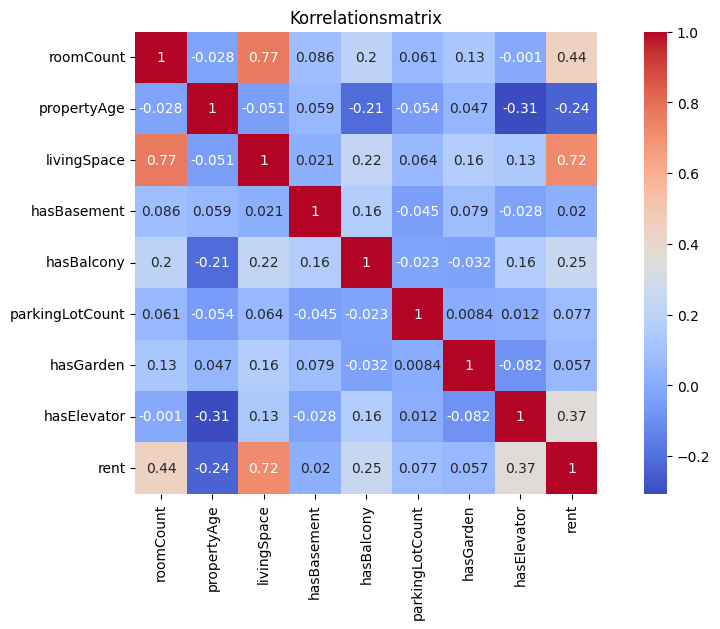

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Daten aus JSON-Datei lesen
data = pd.read_json('smallDataTest.json')

# Numerische Attribute auswählen (ohne Textattribute wie "houseType" oder "address")
numeric_cols = ["roomCount", "propertyAge", "livingSpace", "hasBasement", "hasBalcony", "parkingLotCount", "hasGarden", "hasElevator", "rent"]

# Korrelationsmatrix berechnen
corr_matrix = data[numeric_cols].corr()

# Heatmap erstellen
plt.figure(figsize=(12, 6))  # Neue Größe der Grafik
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", square=True)
plt.title("Korrelationsmatrix")
plt.show()


Nach der Heatingmap zu Urteilen, sollte der Wohnraum mit einem Korrelationskoeffizienten von 0.72XX auf jeden Fall berücksichtigt werden. Da das Modell im Nachhinein noch angepasst wurde, erfolgte im Modell direkt die preisschätzung je qadratmeter.

In [ ]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from sklearn.neighbors import BallTree
import ipywidgets as widgets
from IPython.display import display
import folium
import geopandas as gpd
from shapely.geometry import Point

data = pd.read_json('trainingData_located20XX.json')  #smallDataTest.json
data['quadratmeterpreis'] = data['rent'] / data['livingSpace']  # hinzufügen
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))
gdf_sindex = gdf.sindex


# Load your model here
model = load_model('rent_per_sqm_model_nn.h5')

def geocode_address(address):
    # Implement geocoding here, for example using Nominatim
    geolocator = Nominatim(user_agent="geoapiExercises")
    location = geolocator.geocode(address)
    return (location.latitude, location.longitude) if location else None

def find_nearby(point, gdf, num_points=5):
    # Convert input point to Shapely point object
    point = Point(point)
    
    # Find indices of nearest points
    indices = list(gdf_sindex.nearest(point.bounds, num_points))

    # Get nearest points
    nearest_points = gdf.iloc[indices]
    
    desc = nearest_points['quadratmeterpreis'].describe().drop(['25%', '50%', '75%'])
    desc.index = ['count_nearby', 'mean_rent_per_sqm_nearby', 'std_rent_per_sqm_nearby', 
              'min_rent_per_sqm_nearby', 'max_rent_per_sqm_nearby']

    # Return the coordinates of the reference points as well
    return desc, nearest_points[['Latitude', 'Longitude']]



def predict(address, living_space):
    # Calculate the coordinates of the address
    coordinates = geocode_address(address)
    
    if coordinates:
        nearby_features, reference_points = find_nearby(coordinates, gdf)

        input_data = {
            'roomCount': 2,
            'propertyAge': 2,
            'livingSpace': living_space,
            'hasBasement': False,
            'hasBalcony': True,
            'parkingLotCount': 0,
            'hasGarden': False,
            'hasElevator': True,
            'houseType': 0, #'apartment' -> Fallunterscheidung noch behandeln
            # Add other necessary features here
            # 'feature_name': value,
        }

        prediction_data = input_data.copy()

        # Update the prediction data with the nearby features
        prediction_data.update(nearby_features.to_dict())
        #print(prediction_data)

        # Preprocess the prediction data the same way as you did with your training data
        prediction_data = pd.DataFrame([prediction_data])

        # Zum Laden
        scaler = joblib.load('scaler1.pkl')
        prediction_data = scaler.transform(prediction_data)  # Use the same scaler you used for your training data

        prediction = model.predict(prediction_data)

        return prediction[0][0], prediction_data, coordinates, reference_points
    
    return None, None, None, None

def predict_button_clicked(b):
    address = address_widget.value
    living_space = living_space_widget.value

    prediction, prediction_data, coordinates, reference_points = predict(address, living_space)
    
    if prediction:
        display(widgets.Label(value=f'Prediction: {round(prediction * living_space, 1)}€'))
        
        if coordinates is not None:
            # Create the folium map
            m = folium.Map(location=[coordinates[0], coordinates[1]], zoom_start=14)

            # Add marker for the predicted location
            folium.Marker([coordinates[0], coordinates[1]]).add_to(m)

            # Add lines to the reference points
            for _, row in reference_points.iterrows():
                folium.PolyLine([(coordinates[0], coordinates[1]), (row['Latitude'], row['Longitude'])], color="blue", weight=2.5, opacity=1).add_to(m)
            
            # Display the map
            display(m)
        
        display(pd.DataFrame(prediction_data))
    else:
        display(widgets.Label(value='Cannot geocode address.'))

# Define the input widgets
address_widget = widgets.Text(description='Address')
living_space_widget = widgets.FloatText(description='Living Space (sqm)')

# Create the predict button
predict_button = widgets.Button(description='Predict')
predict_button.on_click(predict_button_clicked)

# Display the input widgets and predict button
display(address_widget, living_space_widget, predict_button)

# Display the input widgets and predict button
display(address_widget, living_space_widget, predict_button)



Text(value='', description='Address')

FloatText(value=0.0, description='Living Space (sqm)')

Button(description='Predict', style=ButtonStyle())

Text(value='', description='Address')

FloatText(value=0.0, description='Living Space (sqm)')

Button(description='Predict', style=ButtonStyle())

1/1 [==============================] - 0s 117ms/step


Label(value='Prediction: 407.1€')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.641005,-1.216714,-0.385411,-1.438575,0.729241,-0.244665,-0.5,1.652996,-0.615741,5.065788,0.026533,0.179972,0.040437,0.248119


In [ ]:
Schulterblatt 121, 20357 Hamburg